In [1]:
if length(LOAD_PATH)<3
    push!(LOAD_PATH,"/Users/wrsweeney/Box Sync/Research/SALT")
end

using SALT_2d
using PyPlot

In [ ]:
dx = .001
dy = .001
N = 100
k = 7*[1,5]/sqrt(26)

x = [i*dx + 0*dy for i in 0:N, j in 0:N]
y = [0*dx + j*dy for i in 0:N, j in 0:N]
f = exp(1im*(x*k[1]+y*k[2]))
#pcolormesh(x,y,real(f))
#inputs = processInputs()
#inputs["N_ext"] = [N,N]
#inputs["x_ext"] = [i*dx for i in 0:N]
#inputs["u_ext"] = [j*dy for j in 0:N]
#inputs["ℓ_ext"] = [N*dx, N*dy]
∇ₓ,∇ᵤ = SALT_2d.Core.grad([N+1,N+1],[dx,dy])
plot(real(-(∇ₓ.'*∇ₓ+∇ᵤ.'*∇ᵤ)*f[:]./f[:]))

In [ ]:
pcolormesh(full(∇ₓ))

In [ ]:
pcolormesh(full(∇ᵤ.'*∇ᵤ))
figure()
pcolormesh(full(∇ₓ.'*∇ₓ))
figure()
pcolormesh(full(∇ₓ.'*∇ₓ+∇ᵤ.'*∇ᵤ))

In [ ]:
k'*k

In [2]:
inputs = processInputs()
k,ψ = computePolesL(inputs, 20, 1, F = 0.,truncate = true)
k

1-element Array{Complex{Float64},1}:
 20.0338-0.0356435im

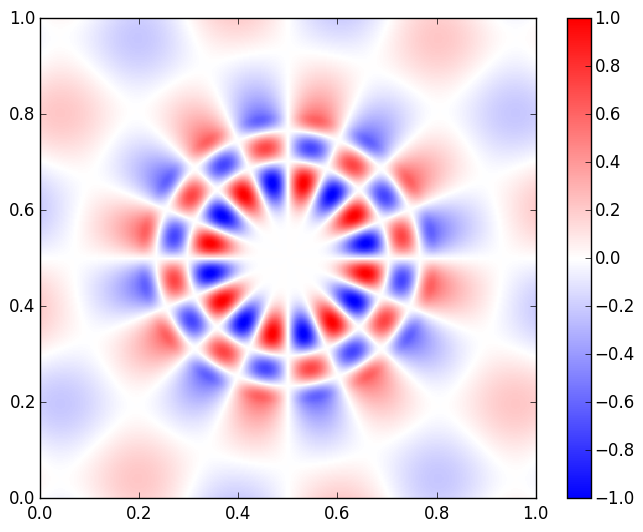

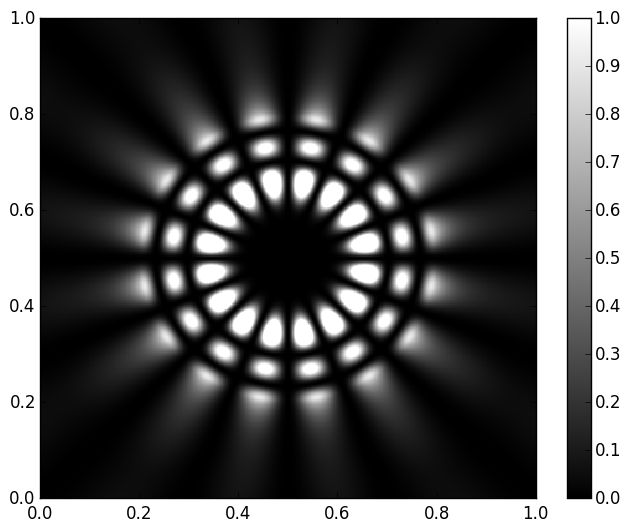

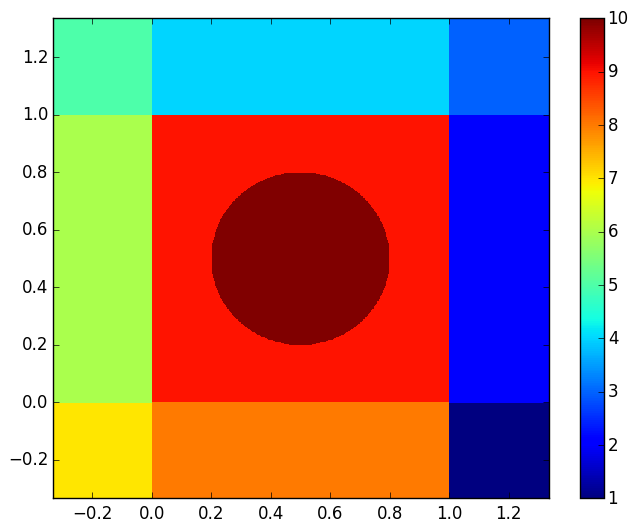

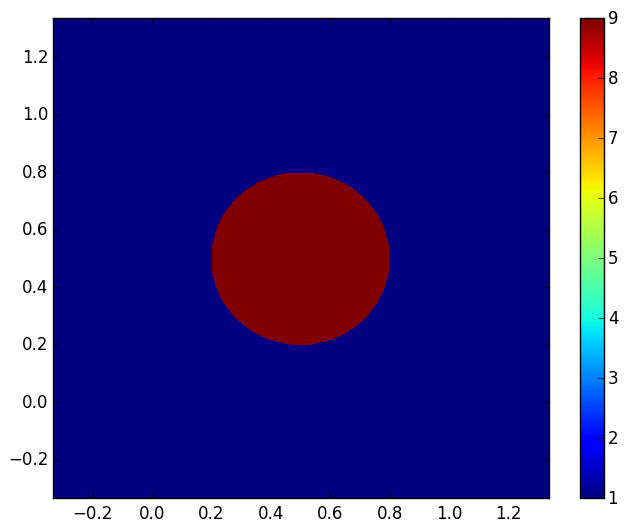

PyObject <matplotlib.colorbar.Colorbar instance at 0x31ab98bd8>

In [5]:
ψ_plot = reshape(ψ[:,1],(inputs["N"][1],inputs["N"][2]))

pcolormesh(inputs["x"],inputs["u"],real(ψ_plot).',cmap = "bwr")
colorbar()
clim([-1,1])
xlim([inputs["∂"][1],inputs["∂"][2]])
ylim([inputs["∂"][3],inputs["∂"][4]])

figure(2)
pcolormesh(inputs["x"],inputs["u"],abs2(ψ_plot).',cmap = "gray")
colorbar()
clim([0,1])
xlim([inputs["∂"][1],inputs["∂"][2]])
ylim([inputs["∂"][3],inputs["∂"][4]])

figure(3)
r = SALT_2d.Core.whichRegion( (inputs["x_ext"],inputs["u_ext"]) ,inputs["∂_ext"],inputs["geometry"])
pcolormesh(inputs["x_ext"],inputs["u_ext"],r)
xlim([inputs["∂_ext"][1],inputs["∂_ext"][2]])
ylim([inputs["∂_ext"][3],inputs["∂_ext"][4]])
colorbar()

figure(4)
pcolormesh(inputs["x_ext"],inputs["u_ext"],inputs["ɛ_ext"][r])
xlim([inputs["∂_ext"][1],inputs["∂_ext"][2]])
ylim([inputs["∂_ext"][3],inputs["∂_ext"][4]])
colorbar()

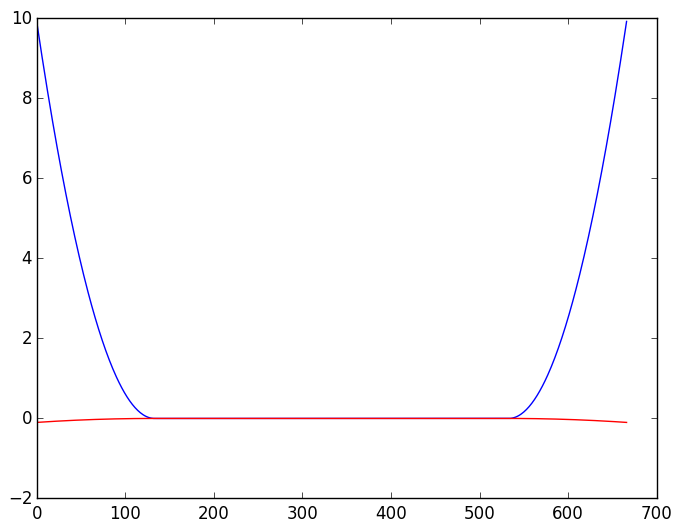

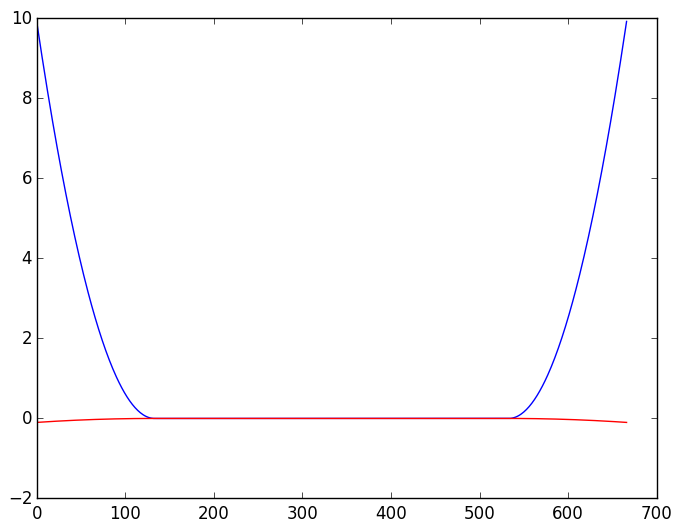

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x33046cf90>

In [4]:
inputs = processInputs()
sₓ,sᵤ = SALT_2d.Core.σ( (inputs["x_ext"],inputs["u_ext"]) ,inputs["∂_ext"], inputs["geometry"])
figure(2)
plot(real(sₓ),"b")
plot(imag(sₓ),"r")
figure(3)
plot(real(sᵤ),"b")
plot(imag(sᵤ),"r")

In [ ]:
size(σ)

In [ ]:
ψ_plot = reshape(ψ[:,2],(inputs["N_ext"][1],inputs["N_ext"][2]))#[inputs["x_inds"],inputs["u_inds"]]
pcolormesh(real(ψ_plot).',cmap = "bwr")
colorbar()
#clim([-1,1]*.004)

figure(2)
pcolormesh(abs2(ψ_plot).',cmap = "gray")
colorbar()

In [ ]:
figure(2)
plot(real(ω)*3/π,imag(ω),"o")
ylim([-1,0])
grid(true)

In [ ]:
N = 50
δD = .005

Ω = NaN*zeros(Complex128,N,length(ω))

for j in 1:length(ω)
    println(j)
    inputs["D₀"] = 0.
    for i in 1:N
        println(i)
        if i > 1
            temp = computePolesNL(inputs,Ω[i-1,j],(.05,.05), Nq = 25, nevals = 2)
        else
            temp = computePolesNL(inputs,ω[j]    ,(.05,.05), Nq = 25, nevals = 2)
        end
        inputs["D₀"] += δD
        Ω[i,j] = temp[1]
    end
end

In [ ]:
plot(real(Ω)*3/π,imag(Ω),"o")
grid(true)

In [ ]:
D_ind = zeros(Int32,size(Ω,2))
for j in 1:size(Ω,2)
    D_ind[j] = find(imag(Ω[:,j]).≥0)[1]-1
end
D_min,dummy = findmin(D_ind)
dummy,ind = findmax(imag(Ω[D_min,:]))

D1 = δD*(D_min-1)
D2 = D1 + δD
temp = Ω[D_min,ind]

for i in 1:5
    inputs["D₀"] = copy((D1+D2)/2)
    temp = computePolesNL(inputs,temp[1],(.05,.05), Nq = 25, nevals = 2)
    if imag(temp[1])≥0
        D2 = copy(inputs["D₀"])
    else
        D1 = copy(inputs["D₀"])
    end
end
temp[1]*3/π

In [ ]:
inputs["D₀"] = D2
ω1,ψ = computePolesL(inputs, temp[1], 1, F = inputs["γ⊥"]/(temp[1]-inputs["ω₀"]+1im*inputs["γ⊥"]))
ψ_plot = reshape(ψ[:,1],(inputs["N_ext"][1],inputs["N_ext"][2]))
pcolormesh(abs2(ψ_plot).',cmap = "gray")
colorbar()
ω1

In [ ]:
# TEST SPA scattered
inputs["a"] = 1.
inputs["D₀"] = .2
ψ = solve_SPA(inputs, real(ω1[1]), z₀=.15im)

In [ ]:
ψ_plot = reshape(ψ[:,1],(inputs["N"][1],inputs["N"][2]))
pcolormesh(real(ψ_plot).',cmap = "bwr")
colorbar()

In [ ]:
# TEST SCATTER SOLVER
Ψ = solve_scattered(inputs, real(ω1[1]); isNonLinear=true,ψ_init = ψ)

In [ ]:
# TEST SPA Lasing
a = copy(inputs["a"])
inputs["a"] = 0.
inputs["D₀"] = D2
ψ₊,ψ₋,dummy = solve_SPA(inputs, real(ω1[1]),z₀₊=.0001im,z₀₋=.0001im)

plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
hold(true)
plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]));

In [ ]:
# TEST LASING SOLVER
ψ₊ = 1im*ψ₊/exp(1im*angle(ψ₊[1]))
ψ₋ = 1im*ψ₋/exp(1im*angle(ψ₋[1]))
ψ,ω = solve_lasing(inputs, inputs["D₀"], ψ_init=ψ₊,ω_init = real(ω1[1]), inds = 14)
ω

In [ ]:
figure(1)
plot(abs2(ψ[inputs["x_inds"]]))

In [ ]:
# TEST S-MATRIX COMPUTATION
inputs["D₀"] = D2
inputs["a"] = 1.
S = computeS(inputs, 20; isNonLinear=true);

In [ ]:
T₊ = abs2(squeeze(S[2,1,:],(1,2)))
T₋ = abs2(squeeze(S[1,2,:],(1,2)))
R₊ = abs2(squeeze(S[1,1,:],(1,2)))
R₋ = abs2(squeeze(S[2,2,:],(1,2)))
plot(inputs["ω"]*3/π,T₊)
hold(true)
plot(inputs["ω"]*3/π,T₋)
plot(inputs["ω"]*3/π,R₊,"x")
plot(inputs["ω"]*3/π,R₋,"x")

In [ ]:
r = SALT_2d.Core.whichRegion((inputs["x_ext"],inputs["u_ext"]),inputs["∂_ext"],inputs["geometry"])
pcolormesh(r)

In [ ]:
456^2

In [ ]:
ψ

In [ ]:
S = [[3 4 5 6; 5 6 32 5; 4 9 8 5];[3 4 5 6; 5 6 32 5; 4 9 8 5] ]

In [ ]:
function myfun(Q::Array{Int,2})
    Q
end

In [ ]:
myfun(S)

In [ ]:
S

In [ ]:
inputs["x_ext"]

In [ ]:
ψ[inputs["x_inds"]]

In [ ]:
inputs["u_inds"]

In [ ]:
[1 2 3;4 5 6; 7 8 9][:]

In [ ]:
ψ[:,1]

In [ ]:
reshape(ψ[:,1],(inputs["N_ext"][1],inputs["N_ext"][2]))[inputs["x_inds"],inputs["u_inds"]][:]

In [ ]:
301*101

In [ ]:
ψ[(inputs["x_inds"]*ones(Int,size(inputs["u_inds"]'))+(ones(Int,size(inputs["x_inds"]))*(inputs["u_inds"]-1)')*inputs["N_ext"][1])[:],1]

In [ ]:
inputs["x_inds"] + (inputs["u_inds"]-1)*inputs[N_]

In [ ]:
453*153

In [ ]:
inputs = processInputs()
r = SALT_2d.Core.whichRegion((inputs["x_ext"],inputs["u_ext"]),inputs["∂_ext"],inputs["geometry"])[inputs["xu_inds"]]
inputs["ɛ_ext"][r]

In [ ]:
pcolormesh(reshape(inputs["ɛ_ext"][r],inputs["N"][1],inputs["N"][2]))
colorbar()

In [ ]:
prod(inputs["N"])

In [ ]:
size(r)

In [ ]:
inputs["∂_ext"]

In [ ]:
20.1509-0.00145112im
 20.1579-0.00137867im
 19.7478-0.0842506im

In [ ]:
20.1355-0.000747291im
 20.1451-0.000773858im
 19.7416-0.0636089im 

In [ ]:
 20.1355-0.000685363im
 20.1452-0.000676246im
 19.7361-0.0735497im 

In [ ]:
(20.0833-0.321419im)/(14.207313875647193 - 0.22496329561476933im)